In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import copy

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"
# device = 'cpu'

CUDA is available!


In [3]:
supervised_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/train/"
val_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/validation/"
test_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/eight_type/test/"
unsupervised_path = "/home/chisc/workspace/wuzhenrong/galaxy/unsuper/images_gz2/"
batch_size = 8
train_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(100, 100)),
                                  transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
                                  transforms.ToTensor()])
train_data = ImageFolder(supervised_path, transform=train_trans)
train_loader = DataLoader(train_data, pin_memory=True, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((256, 256)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

unsuper_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
                                  transforms.Resize((256, 256)),
#                                   transforms.RandomCrop(size=(200, 200)),
#                                   transforms.Resize((256, 256)),
#                                   transforms.CenterCrop(200),
#                                   transforms.Resize((256, 256)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(contrast=0.8),
#                                   transforms.RandomResizedCrop((224, 224)),
                                  transforms.ToTensor()])
unsuper_data = ImageFolder(unsupervised_path, transform=unsuper_trans)
unsuper_loader = DataLoader(unsuper_data, pin_memory=True, batch_size=batch_size, shuffle=True)

tensor([4, 2, 5, 4, 4, 0, 6, 5])
tensor(4)


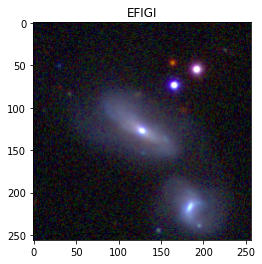

tensor(2)


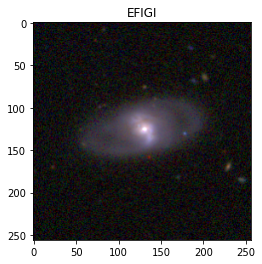

tensor(5)


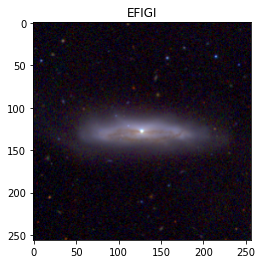

tensor([0, 0, 0, 0, 0, 0, 0, 0])
tensor(0)


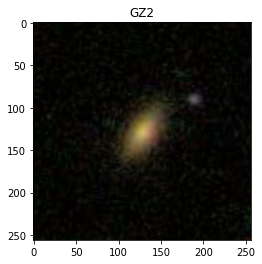

tensor(0)


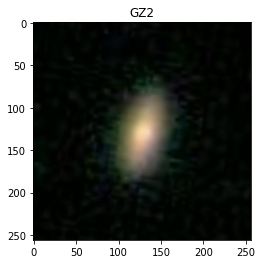

tensor(0)


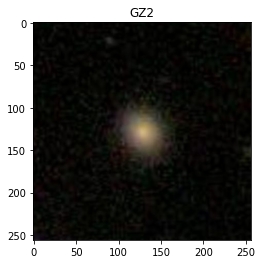

In [4]:
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
    print(labels[i])
    plt.figure(i)
    plt.title('EFIGI')
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()
    
un_images, un_labels = next(iter(unsuper_loader))
print(un_labels)
for i in np.arange(3):
    print(un_labels[i])
    plt.figure(i)
    plt.title('GZ2')
    plt.imshow(un_images[i].permute(1, 2, 0))
    plt.show()

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Conv2d(512, 512, 3, padding=1)
        )
    def forward(self, x):
        return self.encoder(x)


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 64, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(64,  32, kernel_size=4, stride=4),
            nn.ReLU(),
            nn.ConvTranspose2d(32,  3, kernel_size=4, stride=4)
#             nn.ReLU(),
#             nn.ConvTranspose2d(16,  3, kernel_size=2, stride=2)
        )
 
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
# loss_fn = nn.MSELoss()
# min_loss = 10000.
# model = AutoEncoder().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
# for epoch in range(2):
#     t = tqdm(unsuper_loader)
#     for x, _ in t:
#         x = x.to(device)
#         optimizer.zero_grad()
        
#         predict = model(x)
# #         print(x.shape)
# #         print(predict.shape)
#         loss = loss_fn(predict, x)
#         loss.backward()
#         t.set_description(f"loss: {loss:.10f}")
#         if loss < min_loss:
#             min_loss = loss
#             torch.save(model, 'semi_supervised.pkl')
#         t.refresh()
#         optimizer.step()
        
# print()
# print("pretraining is done!")

  0%|          | 0/30430 [00:00<?, ?it/s]

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/30430 [00:00<?, ?it/s]


pretraining is done!


In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = Encoder()
#         self.cnn = nn.Sequential(
#             nn.Conv2d(256, 256, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(256, 512, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0),
#             nn.Conv2d(512, 512, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2, 0)
#         )
        self.fc = nn.Sequential(
            nn.Linear(8192, 1024),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(256, 8),
        )
 
    def forward(self, x):
        x = self.encoder(x)
#         x = self.cnn(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [8]:
# model = torch.load('semi_supervised.pkl')
# finetune_loss_fn = nn.CrossEntropyLoss()

# finetune_model = CNN().to(device)
# finetune_optimizer = torch.optim.Adam(finetune_model.parameters(), lr=3e-4, weight_decay=1e-5)
# finetune_model.encoder.load_state_dict(copy.deepcopy(model.encoder.state_dict())) # loads encoder weights from pretrained model

# for epoch in range(20):
#     t = tqdm(train_loader)
#     for x, y in t:
# #         x, y = map(lambda x: x.to(device), [x, y]) # to device, just never mind it.
#         x, y = x.to(device), y.to(device)
# #         print(x.shape)
# #         print(y.shape)
#         finetune_optimizer.zero_grad()
#         logits = finetune_model(x)
# #         print(logits.shape)
#         logits = logits.to(device)
#         loss = finetune_loss_fn(logits, y)
#         loss.backward()
#         t.set_description(f"loss: {loss:.10f}")
#         t.refresh()
#         finetune_optimizer.step()

# print()
# print("finetune is done!")

In [ ]:
pre_model = torch.load('semi_supervised.pkl')
finetune_model = CNN().to(device)
optimizer = torch.optim.Adam(finetune_model.parameters(), lr=3e-4, weight_decay=1e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()
finetune_model.encoder.load_state_dict(copy.deepcopy(pre_model.encoder.state_dict())) # loads encoder weights from pretrained model
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
# l1_crit = nn.L1Loss(size_average=False)
# factor = 0.03
n_epochs = 20
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    finetune_model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = finetune_model(x)
#         reg_loss = 0
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss)
    train_acc_record.append(train_acc)

    finetune_model.eval()
    for x, y in tqdm(val_loader):
        x, y = x.to(device), y.to(device)
        prediction = finetune_model(x)
#         reg_loss = 0
        
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        val_acc += acc/len(val_loader)
        val_loss += loss/len(val_loader)
        if loss < min_loss:
            min_loss = loss
            torch.save(model, 'E_I_S_new.pkl')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss)
    val_acc_record.append(val_acc)
# torch.save(model, 'E_I_Sc.pkl')

  0%|          | 0/241 [00:00<?, ?it/s]

[ Train | 1/20 ] loss = 1.94967, acc = 0.22701


  0%|          | 0/145 [00:00<?, ?it/s]

In [10]:
!nvidia-smi

Thu Aug 26 23:45:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 207...  On   | 00000000:01:00.0 Off |                  N/A |
| 38%   54C    P2    42W / 215W |   1887MiB /  7981MiB |     17%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [11]:
actu = []
ai_pred = []
model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    prediction = finetune_model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(test_loader)
    test_loss += loss/len(test_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

RuntimeError: 1only batches of spatial targets supported (3D tensors) but got targets of size: : [1]

In [13]:
model = torch.load('E_I_S_new.pkl')
galaxy_type = ['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc']
loss_func = nn.CrossEntropyLoss()
i = 0
for x, y in test_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    ans = galaxy_type[y[0]]
    pre = galaxy_type[out[0]]
    if i % 10 == 0:
        
        plt.figure(i)
        plt.title(f'Predict: {pre}, Answer: {ans}')
#         if out[0] == 0:
            
#         elif out[0] == 1:
#             plt.title(f'Predict: {pre}, Answer: {ans}')
#         else:
#             plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

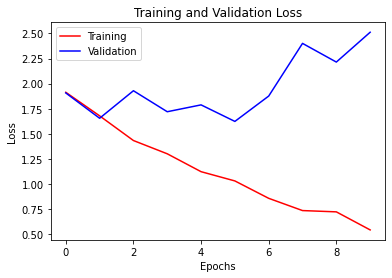

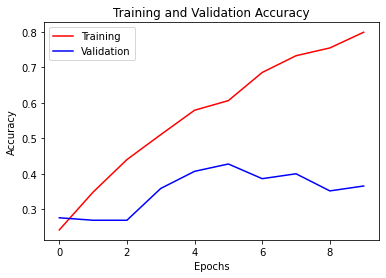

In [14]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [12]:
confmat = confusion_matrix(y_true=actu, y_pred=ai_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.show()